# DTM extraction from DSM (and orthophotos), using different models trained with GAN

This notebook shows the steps to generate DTMs, using either just a DSM or a DSM with orthophotos, using generator models trained in a GAN framework.<br>
In one case the orthophotos are directly used in the generator's input, and in the other they are used to generate a semantic map, which is itself integrated in the generator's input

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import model_fcts as mod
import os
import preprocessing_fcts as pp
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
RES = 512 # either 512 or 256 according to the size of the images
PATH = 'np_dataset/' + str(RES) + '/val/' #directory with the image files


In [3]:
def np_dataset_generator(path):
    id_list = os.listdir(path)
    for name in id_list:
        im = np.load(path + name)
        yield im

In [4]:
ds = pp.make_tf_dataset(RES, 'val', True) #tensorflow dataset with inputs (arrays with dsm and orthoplan) and dtms
input_ds = ds.map(lambda x, y: x) #tensorflow dataset with only the input
dsms = input_ds.map(lambda x: x[:,:,0])
real_dtms = ds.map(lambda x,y : y)

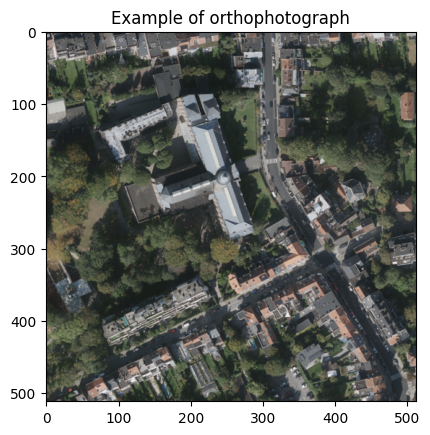

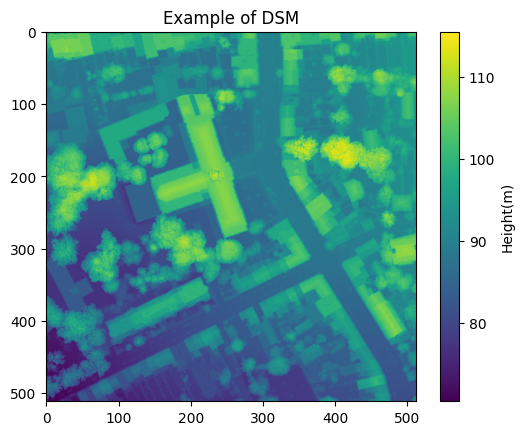

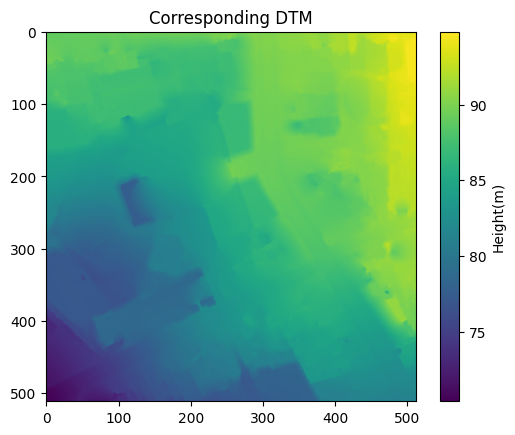

In [5]:
for i in input_ds.take(1):
    plt.imshow(tf.cast(i[:,:,1:], 'int32'))
    plt.title('Example of orthophotograph')
    fig = plt.figure()
    plt.imshow(i[:,:,0])
    cbar = plt.colorbar()
    cbar.set_label('Height(m)')
    plt.title('Example of DSM')
for i in real_dtms.take(1):
    plt.figure()
    plt.imshow(i)
    plt.title('Corresponding DTM')
    cbar = plt.colorbar()
    cbar.set_label('Height(m)')

## GAN to extract DTM from DSM

In [6]:
model_names = os.listdir('training_checkpoints')
for i, name in enumerate(model_names):
    print(i, name)

0 seg
1 gan_sem_map
2 pix_fm
3 pix_rgb
4 drib_fm
5 pix_grad
6 TEST
7 pix_rgb_grad
8 drib
9 pix2pix
10 pix_grad_fm
11 gan_sem_map_grad
12 pix512
13 rgb_grad_fm


In [7]:
models = [{'name':'pix_grad', 'gen_type':'Generator256', 'res':256, 'rgb':False, 'fm':False, 'deconv':True}]

In [8]:
def get_inp_channels(rgb):
    inp_channels = 1
    if rgb:
        inp_channels += 3
    return inp_channels


def load_gen(name, gen_type, res, rgb, fm, deconv):
    """
    Function that returns a generator from the 'training_checkpoints' checkpoints directory
    inputs : 
    - name : str, name of the generator
    - gen_type : string corresponding to a generator defined in 'model_fcts.py'
    - res : int, either 256 or 512 for an input DSM of either 256x256 or 512x512 pixels
    - rgb : bool, whether or not the rgb channels of the orthophotographs are included in the input. If False, only the DSM 
    - fm : bool, whether or not feature matching is used
    - deconv: bool, whether or not deconvolutions are used in the generator. If false, the alternative upsampling method is used
    """
    net_gen = getattr(mod, gen_type)
    inp_channels = get_inp_channels(rgb)  
    gen = net_gen(inp_channels, res, deconv=deconv)
    checkpoint = tf.train.Checkpoint(generator=gen)
    checkpoint.restore('training_checkpoints/' + name + '/ckpt-1').expect_partial()
    
    return gen

In [9]:
gen = load_gen(**models[0])

#### If the dsms are 512x512 pixels, they have to be split into 4 256x256 pixels images

In [10]:
def divide_tensor(image):
    return tf.convert_to_tensor([image[0:256,0:256], image[0:256,256:512], image[256:512,0:256], image[256:512,256:512]])

In [11]:
#skip if the dsms are already 256x256 pixels
dsms = dsms.map(lambda x: divide_tensor(x))
dsms = dsms.flat_map(tf.data.Dataset.from_tensor_slices) 
real_dtms = real_dtms.map(lambda x: divide_tensor(x))
real_dtms = real_dtms.flat_map(tf.data.Dataset.from_tensor_slices)

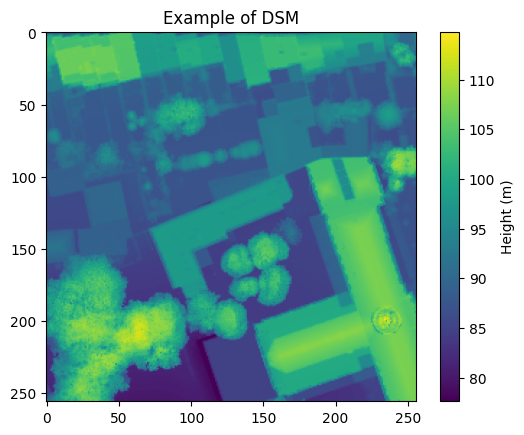

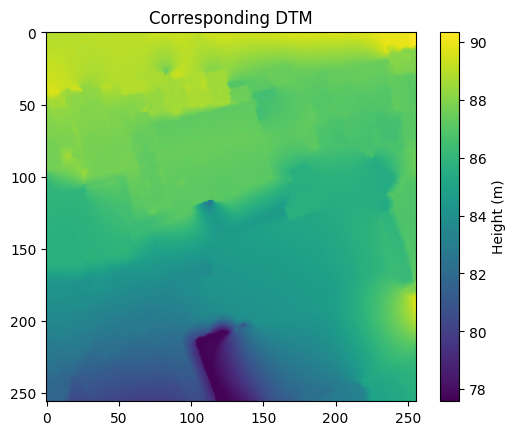

In [12]:
for i in dsms.take(1):
    plt.imshow(i)
    plt.title('Example of DSM')
    cbar = plt.colorbar()
    cbar.set_label('Height (m)')
for i in real_dtms.take(1):
    plt.figure()
    plt.imshow(i)
    plt.title('Corresponding DTM')
    cbar = plt.colorbar()
    cbar.set_label('Height (m)')

#### Normalization

In [13]:
n_dsms = dsms.map(lambda x : (x,(tf.math.reduce_max(x), tf.math.reduce_min(x))))
n_dsms = n_dsms.map(lambda x, y:(tf.expand_dims(pp.normalize(x, y[0], y[1]), axis=-1))).batch(1)

In [14]:
n_dtms = gen.predict(n_dsms) #the predictions are made from normalized dtms, they are therefore not in the original height range

516/516 [==============================] - 10s 15ms/step


"Denormalization" to map the predicted DTMs back to the correct height range

In [15]:
dtms = []
h_range=dsms.map(lambda x: ((tf.math.reduce_max(x), tf.math.reduce_min(x))))
i = 0
for l in h_range.as_numpy_iterator():
    dtm = pp.denormalize(n_dtms[i],l[0],l[1])
    dtm = dtm[:,:,0]
    dtms.append(dtm)
    i += 1

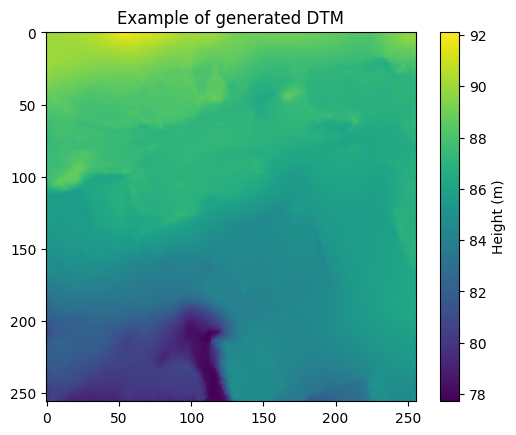

In [16]:
plt.imshow(dtms[0])
plt.title('Example of generated DTM')
cbar = plt.colorbar()
cbar.set_label('Height (m)')

### Measure the accuracy of the generated DTMs with respect to the real DTMs

In [17]:
def rmse(preds, real_dtms, res):
    ssum = 0
    ssum_L1 = 0
    n = res**2
    i = 0
    for j in real_dtms.as_numpy_iterator():
        dif = np.sum((preds[i] - j)**2)
        dif_L1 = np.sum(tf.abs((preds[i] - j)))
        ssum += dif
        ssum_L1 += dif_L1
        i += 1

    print('RMSE = ' + str(np.sqrt(ssum/(i*n))))
    print('MAE = ' + str(ssum_L1/(i*n)))

In [18]:
rmse(dtms, real_dtms, 256)

RMSE = 1.1165535220947007
MAE = 0.5817201983096988


## GAN to extract DTM using DSM and orthophotos

In [19]:
models = [{'name':'rgb_grad_fm', 'gen_type':'Generator256', 'res':256, 'rgb':True, 'fm':True, 'deconv':True}]
gen = load_gen(**models[0])

#### If the dsms are 512x512 pixels, they have to be split into 4 256x256 pixels images

In [20]:
input_ds = input_ds.map(lambda x: divide_tensor(x))
input_ds = input_ds.flat_map(tf.data.Dataset.from_tensor_slices)

#### Normalization

In [21]:
n_input_ds = input_ds.map(lambda x : (x,(tf.math.reduce_max(x[:,:,0]), tf.math.reduce_min(x[:,:,0]))))
n_input_ds = n_input_ds.map(lambda x, y : (tf.concat([tf.expand_dims(pp.normalize(x[:,:,0], y[0], y[1]), axis=-1),pp.normalize_rgb(x[:,:,1:])], axis=-1))).batch(1)

In [22]:
preds = gen.predict(n_input_ds)

516/516 [==============================] - 8s 15ms/step


In [23]:
dtms = []
h_range=input_ds.map(lambda x: ((tf.math.reduce_max(x[:,:,0]), tf.math.reduce_min(x[:,:,0]))))
i = 0
for l in h_range.as_numpy_iterator():
    dtm = pp.denormalize(preds[i],l[0],l[1])
    dtms.append(dtm[:,:,0])
    i += 1

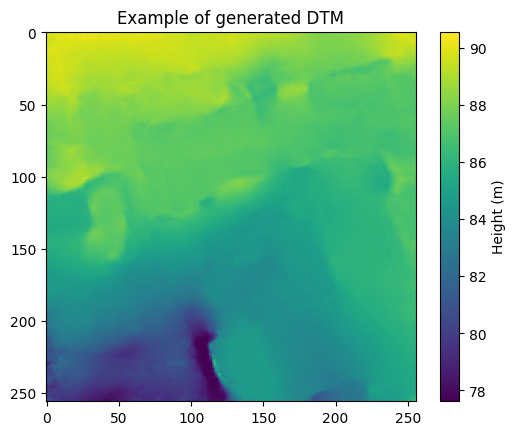

In [24]:
plt.imshow(dtms[0])
plt.title('Example of generated DTM')
cbar = plt.colorbar()
cbar.set_label('Height (m)')

In [25]:
rmse(dtms, real_dtms, 256)

RMSE = 1.0280378215576607
MAE = 0.5286181901776513


## Ground segmentation

In [26]:
import seg_models

#### As this was the configuration with the best results, the segmentation model used takes as input images with spatial resolution of 512x512

In [27]:
name = 'seg_model'
inputs = tf.keras.layers.Input(shape=[512,512, 4])
net = seg_models.PixUnet(inputs, relu=True, activ='sigmoid')
segmentor = mod.Generator(inputs=inputs, outputs=net)
checkpoint = tf.train.Checkpoint(model=segmentor)
checkpoint.restore('training_checkpoints/seg/' + name + '/ckpt-1')

#### Normalization

In [28]:
input_ds = ds.map(lambda x, y: x)
n_input_ds = input_ds.map(lambda x : (x,(tf.math.reduce_max(x[:,:,0]), tf.math.reduce_min(x[:,:,0]))))
n_input_ds = n_input_ds.map(lambda x, y : (tf.concat([tf.expand_dims(pp.normalize(x[:,:,0], y[0], y[1]), axis=-1),pp.normalize_rgb(x[:,:,1:])], axis=-1)))

In [29]:
pred_masks = segmentor.predict(n_input_ds.batch(1))

129/129 [==============================] - 4s 23ms/step


Text(0.5, 1.0, 'Example of semantic map')

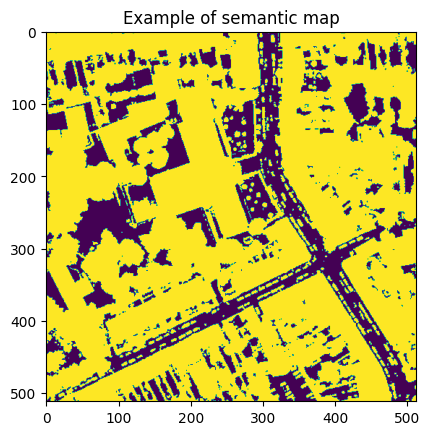

In [30]:
masks = (pred_masks>=0.5).astype('int32')
plt.imshow(masks[0])
plt.title('Example of semantic map')

## DTM extraction with GAN using DSM semantic map

In [31]:
def divide_one_array(image):
    return np.array([image[0:256,0:256], image[0:256,256:512], image[256:512,0:256], image[256:512,256:512]])

def mask_ds_gen():
    for mask in masks256:
            yield mask

In [32]:
masks256 = np.array(list(map(divide_one_array,masks))).reshape(516,256,256,1)
mask_ds = tf.data.Dataset.from_generator(mask_ds_gen, output_signature=(tf.TensorSpec(shape=(256,256,1), dtype=tf.float32)))

dsms = input_ds.map(lambda x: x[:,:,0])
dsms = dsms.map(lambda x: divide_tensor(x))
dsms = dsms.flat_map(tf.data.Dataset.from_tensor_slices)
n_dsms = dsms.map(lambda x : (x,(tf.math.reduce_max(x), tf.math.reduce_min(x))))
n_dsms = n_dsms.map(lambda x, y:(tf.expand_dims(pp.normalize(x, y[0], y[1]), axis=-1)))


n_input_ds = tf.data.Dataset.zip((n_dsms, mask_ds))
n_input_ds = n_input_ds.map(lambda x,y: (tf.concat((x,y),axis=-1))).batch(1)

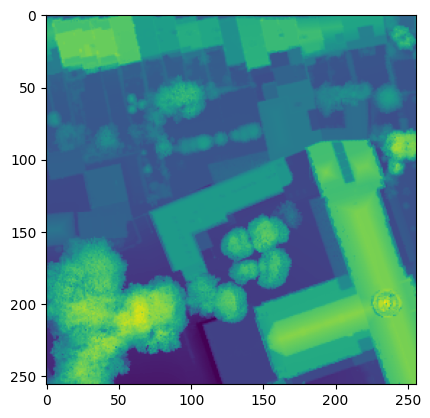

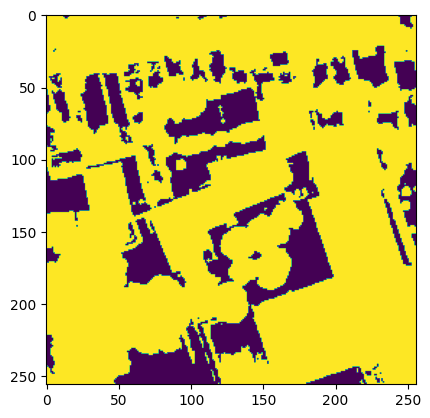

In [33]:
for i in n_input_ds.take(1):
    plt.imshow(i[0][:,:,0])
    plt.figure()
    plt.imshow(i[0][:,:,1])

In [34]:
gen = mod.Generator256(2, 256)
checkpoint = tf.train.Checkpoint(generator=gen)
checkpoint.restore('training_checkpoints/' + 'gan_sem_map' + '/ckpt-1').expect_partial()

In [35]:
preds = gen.predict(n_input_ds)

516/516 [==============================] - 8s 15ms/step


In [36]:
dtms = []
h_range=dsms.map(lambda x: ((tf.math.reduce_max(x), tf.math.reduce_min(x))))
i = 0
for l in h_range.as_numpy_iterator():
    dtm = pp.denormalize(preds[i],l[0],l[1])
    dtms.append(dtm[:,:,0])
    i += 1

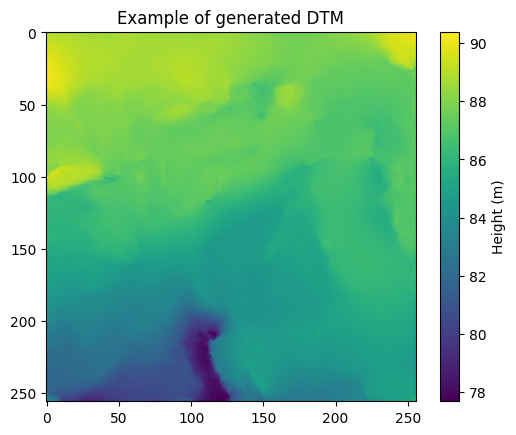

In [37]:
plt.imshow(dtms[0])
plt.title('Example of generated DTM')
cbar = plt.colorbar()
cbar.set_label('Height (m)')

In [38]:
rmse(dtms, real_dtms, 256)

RMSE = 1.037642220345081
MAE = 0.49860286201502


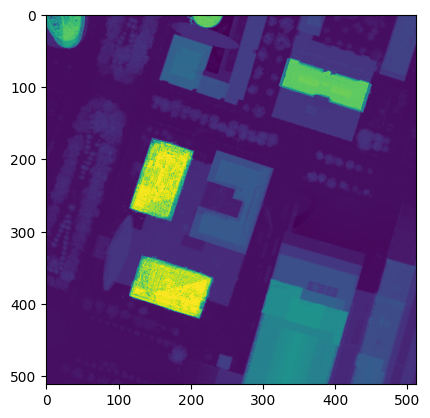

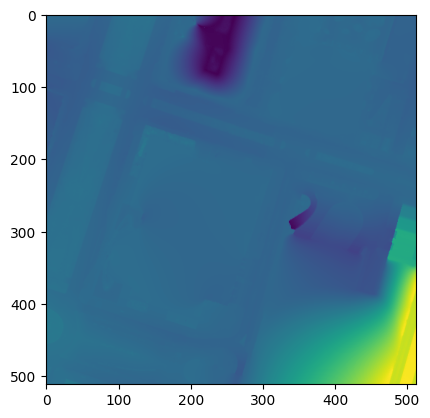

In [39]:
a = pp.make_tf_dataset(512, 'train', False)
for i in a.take(1):
    plt.figure()
    plt.imshow(i[0][:,:,0])
    plt.figure()
    plt.imshow(i[1])